## Анализ embedding-tuned модели с помощью weightwatcher

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip uninstall numba -y && pip install numba

In [3]:
import os
import sys

# Получаем абсолютный путь к корневой директории проекта (директория выше текущей)
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Добавляем корневую директорию в sys.path
if root_path not in sys.path:
    sys.path.append(root_path)

In [4]:
from model_loaders import load_ss_model
import weightwatcher as ww
from pipeline import separate_audio
import torch
from models.clap_encoder import CLAP_Encoder
import IPython.display as ipd
from utils import parse_yaml
from utils import describe_weights
from torch import nn
import numpy as np
import pandas as pd

2024-05-04 20:49:05.853134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 20:49:05.853160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 20:49:05.854047: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 20:49:05.858722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 20:49:06.372581: W tensorflow/compiler/tf2

In [5]:
SS_CONFIG_PATH = '../config/audiosep_base.yaml'
CLAP_CKPT_PATH = '../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt'
AUDIOSEP_CKPT_PATH = '../checkpoint/audiosep_base_4M_steps.ckpt'
classes = ["bass", "drums", "vocals", "other musical instruments"]
device = torch.device('cuda')
configs = parse_yaml(SS_CONFIG_PATH)

In [6]:
query_encoder = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder).eval().to(device)

2024-05-04 20:49:21,904 - INFO - Loading HTSAT-base model config.
2024-05-04 20:49:23,842 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


In [7]:
from models.audiosep_tunned_embeddings import AudioSepTunedEmbeddings

checkpoint_path = '../checkpoints/final/musdb18/embeddings/final.ckpt'

query_encoder_for_lora = CLAP_Encoder(pretrained_path = CLAP_CKPT_PATH).eval().to(device)
base_model_for_lora = load_ss_model(configs=configs, checkpoint_path=AUDIOSEP_CKPT_PATH, query_encoder=query_encoder_for_lora).eval().to(device)

model = AudioSepTunedEmbeddings.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    strict=False,
    ss_model=base_model_for_lora.ss_model,
    query_encoder=base_model_for_lora.query_encoder,
    waveform_mixer=None,
    loss_function=None,
    optimizer_type=None,
    learning_rate=None,
    lr_lambda_func=None,
) \
    .eval() \
    .to(device)


2024-05-04 21:02:37,782 - INFO - Loading HTSAT-base model config.
2024-05-04 21:02:39,122 - INFO - Loading pretrained HTSAT-base-roberta weights (../checkpoint/music_speech_audioset_epoch_15_esc_89.98.pt).


# Посмотрим на среднее alpha query encoder

{'log_norm': 3.1343247371889955, 'alpha': 4.496491728150426, 'alpha_weighted': 6.418481930514178, 'log_alpha_norm': 6.761209070846684, 'log_spectral_norm': 1.5942261192340326, 'stable_rank': 43.433567962107006}


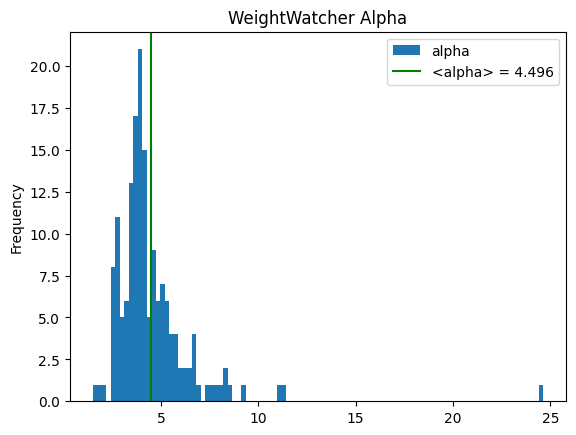

In [9]:
from utils import plot_hist

base_details, base_summary = describe_weights(model.query_encoder)
plot_hist(base_details)
print(base_summary)

Видим, что при дообучении query net адаптером общая alpha немного уменьшилась

In [10]:
ckpt = torch.load(checkpoint_path)['state_dict']
ckpt = {layer: weight for layer, weight in ckpt.items() if 'tuned_embedding' in layer}

In [15]:
details, _ = describe_weights(ckpt)
details[['longname', 'alpha', 'warning']]

,longname,alpha,warning
0,query_encoder.tuned_embedding_layer.0,2.549202,
1,query_encoder.tuned_embedding_layer.2,5.542571,


Видим, что у одного слоя хорошее alpha, близкое к 2, а у другого alpha = 5.54 - близко к границе недообучения. Это происходит из-за небольшого числа тюненых классов. Для датасетов, в которых больше оба слоя должны быть хорошо обученными